# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1097]:
import requests
import json
import time
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm, linear_model, datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import calendar


#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [1096]:
# # Scraping Reddit for posts and comment count

# joke_posts = []
# joke_comments = []


# after = None
# for i in range(80):
#     print(i)
#     if after == None:
#         params = {}
#     else:
#         params = {'after': after}
# #     url = 'https://www.reddit.com/r/Jokes/hot/.json'
#     url = 'https://www.reddit.com/r/Jokes/top/.json?t=month'
#     headers = {'User-agent': 'Jordan Arnold Bot 0.1'}
#     res = requests.get(url, params=params, headers=headers)
#     if res.status_code == 200:
#         data = res.json()
#         temp_joke_posts = data['data']['children']
#         joke_posts.extend(temp_joke_posts)
#         for j in range(0, len(temp_joke_posts)):
#             url2 = 'http://reddit.com/r/Jokes/'
#             slug_id = data['data']['children'][j]['data']['id']
#             res2 = requests.get(url2 + 'comments/' + slug_id + '.json', headers = headers)
#             if res.status_code == 200:
#                 data2 = res2.json()
#                 temp_joke_comments = data2[1]['data']['children']
#                 joke_com = []
#                 for k in range(0, len(temp_joke_comments)-1): 
#                     com_time = datetime.datetime.fromtimestamp(temp_joke_comments[k]['data']['created_utc']).strftime('%Y-%m-%d %H:%M:%S')
#                     com_time = datetime.datetime.strptime(com_time, "%Y-%m-%d %H:%M:%S")
#                     post_time = datetime.datetime.fromtimestamp(temp_joke_posts[j]['data']['created_utc']).strftime('%Y-%m-%d %H:%M:%S')
#                     post_time = datetime.datetime.strptime(post_time, "%Y-%m-%d %H:%M:%S")
#                     diff = com_time - post_time
#                     if diff.seconds <=172800:
#                         joke_com.append(temp_joke_comments[k]['data']['body'])  
#                 joke_comments.append(len(joke_com))                
#             else:
#                 print(res.status_code)
#                 break
            
#     else:            
#         print(res.status_code)
#         break
#     after = data['data']['after']
#     time.sleep(18)




In [1117]:
posts = []
comment_links = []

after = None
for i in range(40):
    print(i)
    if after == None:
        params = {}
    else:
        params = {'after': after}
#     url = 'https://www.reddit.com/hot/.json'
    url = 'https://www.reddit.com/top/.json?sort=top&t=month'
    headers = {'User-agent': 'Jordan Arnold Bot 0.1'}
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        data = res.json()
        posts.extend(data['data']['children'])

        after = data['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(3)

print(len(posts))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
998


## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [1174]:
# Creating list of post titles
titles = []
title_length = []
subs = []
comment_count = []
scores = []
post_text = []
text_length = []
times = []
over_eighteen = []
names = []
ups = []
hours = []
days = []
links = []
cross_posts = []
videos = []
memes = []
sub_subscribers = []
stickies = []


for i in range(0, len(posts)):
    titles.append(posts[i]['data']['title'])
    title_length.append(len(posts[i]['data']['title']))
    subs.append(posts[i]['data']['subreddit'])
    comment_count.append(posts[i]['data']['num_comments'])
    scores.append(posts[i]['data']['score'])
    post_text.append(posts[i]['data']['selftext'])
    text_length.append(len(posts[i]['data']['selftext']))
    times.append((time.time() - posts[i]['data']['created_utc'])/60/60)
    over_eighteen.append(posts[i]['data']['over_18'])
    names.append(posts[i]['data']['name'])
    ups.append(posts[i]['data']['ups'])
    hour = datetime.datetime.fromtimestamp(posts[i]['data']['created_utc']).strftime('%Y-%m-%d %H:%M:%S')
    hour = datetime.datetime.strptime(hour, "%Y-%m-%d %H:%M:%S")
    hours.append(hour.hour)
    day = []
    day = datetime.datetime.fromtimestamp(posts[i]['data']['created_utc']).strftime('%Y-%m-%d %H:%M:%S')
    day = datetime.datetime.strptime(day, "%Y-%m-%d %H:%M:%S")
    day = calendar.day_name[day.weekday()]
    days.append(day)
    links.append(posts[i]['data']['domain'])
    cross_posts.append(posts[i]['data']['num_crossposts'])
    sub_subscribers.append(posts[i]['data']['subreddit_subscribers'])
    stickies.append(posts[i]['data']['stickied'])
    videos.append(posts[i]['data']['is_video'])

# for i in range(0, len(posts)):
#     if 'reddit_video' in posts[i]['data']['media']:
#         videos.append('yes')
#     else:
#         videos.append('no')
#     if posts[i]['data']['media']['oembed'] != None:
#         memes.append(1)
#     else:
#         memes.append(0)
    



# Creating Dataframe

In [1203]:
# Making a dataframe

df = pd.DataFrame([titles, title_length, scores, comment_count, post_text, text_length, over_eighteen, subs, times, names, ups, hours, days, links, cross_posts, sub_subscribers, stickies, videos]).T
df.columns = ['Post Title', 'Title Length', 'Score', 'Comments', 'Text', 'Text Length', 'Over Eighteen', 'Subreddit', 'Amount of Time Posted(in Hours)', 'ID', 'Up Votes', 'Hour Created', 'Day Created', 'Link', 'Cross Posts', 'Subreddit Subscribers', 'Stickied Post', 'Video Present']


In [1204]:
df.head(20)

,Post Title,Title Length,Score,Comments,Text,Text Length,Over Eighteen,Subreddit,Amount of Time Posted(in Hours),ID,Up Votes,Hour Created,Day Created,Link,Cross Posts,Subreddit Subscribers,Stickied Post,Video Present
0,Heat index was 110 degrees so we offered him a...,95,244174,3596,,0,False,aww,132.835,t3_90bu6w,244174,21,Thursday,v.redd.it,77,17601241,False,True
1,"Reddit, Thanos has a message for you...",39,210407,32803,,0,False,thanosdidnothingwrong,405.856,t3_8x2pyo,210407,12,Sunday,v.redd.it,54,551232,False,True
2,VOTE UPWARDS IF YOU'RE STILL UNBANNED TO FLEX ...,64,207214,19903,Edit: STILL HERE BABY WHOOOOOOOOOOOO,36,False,thanosdidnothingwrong,374.312,t3_8xia82,207214,20,Monday,self.thanosdidnothingwrong,4,551232,False,False
3,"Two weeks before his inauguration, Donald J. T...",224,183114,18960,,0,False,worldnews,156.469,t3_901p5f,183114,22,Wednesday,nytimes.com,24,19123346,False,False
4,I work in a kitchen. You have no idea how many...,118,182406,3814,,0,False,pics,697.584,t3_8tzsyf,182406,8,Tuesday,i.redd.it,21,19026915,False,False
5,"I am working on ways to ban half of the sub, t...",166,179453,6959,,0,False,thanosdidnothingwrong,565.909,t3_8vehjn,179453,20,Sunday,i.redd.it,9,551232,False,False
6,The four Thai Navy Seals (one medic) that stay...,222,170629,3762,,0,False,pics,358.699,t3_8xqg68,170629,11,Tuesday,imgur.com,20,19026915,False,False
7,"You've seen a doggo reaction, but have you see...",65,154291,2010,,0,False,gifs,482.332,t3_8w9yre,154291,8,Thursday,i.imgur.com,45,16434616,False,False
8,No one is breaking into this house!,35,149987,1889,,0,False,funny,360.661,t3_8xpbud,149987,9,Tuesday,gfycat.com,43,20106871,False,False
9,My friend was stopped by some tourists to take...,145,148986,3167,,0,False,funny,309.063,t3_8ybuck,148986,13,Thursday,imgur.com,9,20106871,False,False


In [1205]:
df.sort_values('Comments', ascending=False).head()

,Post Title,Title Length,Score,Comments,Text,Text Length,Over Eighteen,Subreddit,Amount of Time Posted(in Hours),ID,Up Votes,Hour Created,Day Created,Link,Cross Posts,Subreddit Subscribers,Stickied Post,Video Present
844,PSA: You will not be banned unless you have a ...,73,51808,73330,The team working on the ban bot's do not have ...,635,False,thanosdidnothingwrong,547.911,t3_8vl3iz,51808,14,Monday,self.thanosdidnothingwrong,2,551230,False,False
130,*SNAP* THE BAN HAS BEGUN,24,89331,56961,,0,False,thanosdidnothingwrong,374.508,t3_8xi3y2,89331,20,Monday,self.thanosdidnothingwrong,5,551231,False,False
845,There will be a sacrifice this evening,38,51778,48017,The sacrifice will take place on the next post...,145,False,thanosdidnothingwrong,453.241,t3_8wlwdh,51778,13,Friday,self.thanosdidnothingwrong,0,551230,False,False
974,"Reddit, Thanos has a message for you...",39,210404,32803,,0,False,thanosdidnothingwrong,405.856,t3_8x2pyo,210404,12,Sunday,v.redd.it,54,551230,False,True
1,"Reddit, Thanos has a message for you...",39,210407,32803,,0,False,thanosdidnothingwrong,405.856,t3_8x2pyo,210407,12,Sunday,v.redd.it,54,551232,False,True


In [1206]:
df.shape

(998, 18)

In [1207]:
df = df.drop_duplicates(subset='ID')

In [1208]:
df.shape

(973, 18)

## Scatterplots

Text(0,0.5,'Comments')

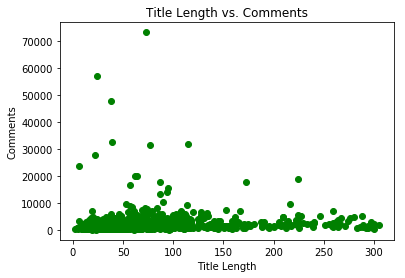

In [1209]:
# Plotting title length vs. comment count

plt.scatter(df['Title Length'], df['Comments'], c='g')
plt.title('Title Length vs. Comments')
plt.xlabel('Title Length')
plt.ylabel('Comments')

Text(0,0.5,'Comments')

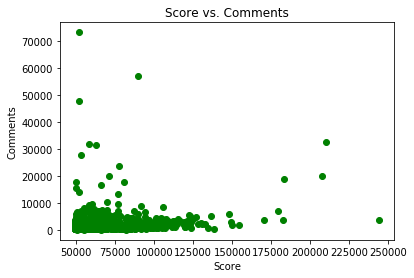

In [1210]:
# Plotting score vs. comment count

plt.scatter(df['Score'], df['Comments'], c='g')
plt.title('Score vs. Comments')
plt.xlabel('Score')
plt.ylabel('Comments')

Text(0,0.5,'Comments')

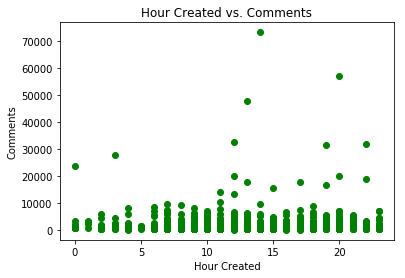

In [1211]:
# Plotting hour created vs. comments

plt.scatter(df['Hour Created'], df['Comments'], c='g')
plt.title('Hour Created vs. Comments')
plt.xlabel('Hour Created')
plt.ylabel('Comments')

Text(0,0.5,'Comments')

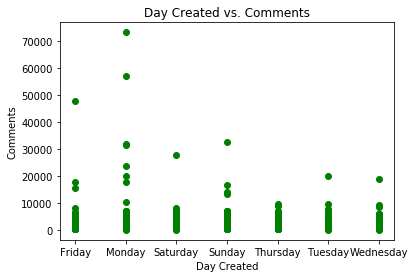

In [1212]:
# Plotting day created vs. comments

plt.scatter(df['Day Created'], df['Comments'], c='g')
plt.title('Day Created vs. Comments')
plt.xlabel('Day Created')
plt.ylabel('Comments')

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [1213]:
# Export to csv
df.to_csv('reddit_posts.csv', index=1)

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [1214]:
reddit = pd.read_csv('reddit_posts.csv')
reddit.head()

,Unnamed: 0,Post Title,Title Length,Score,Comments,Text,Text Length,Over Eighteen,Subreddit,Amount of Time Posted(in Hours),ID,Up Votes,Hour Created,Day Created,Link,Cross Posts,Subreddit Subscribers,Stickied Post,Video Present
0,0,Heat index was 110 degrees so we offered him a...,95,244174,3596,NaN,0,False,aww,132.835239,t3_90bu6w,244174,21,Thursday,v.redd.it,77,17601241,False,True
1,1,"Reddit, Thanos has a message for you...",39,210407,32803,NaN,0,False,thanosdidnothingwrong,405.855517,t3_8x2pyo,210407,12,Sunday,v.redd.it,54,551232,False,True
2,2,VOTE UPWARDS IF YOU'RE STILL UNBANNED TO FLEX ...,64,207214,19903,Edit: STILL HERE BABY WHOOOOOOOOOOOO,36,False,thanosdidnothingwrong,374.311628,t3_8xia82,207214,20,Monday,self.thanosdidnothingwrong,4,551232,False,False
3,3,"Two weeks before his inauguration, Donald J. T...",224,183114,18960,NaN,0,False,worldnews,156.469405,t3_901p5f,183114,22,Wednesday,nytimes.com,24,19123346,False,False
4,4,I work in a kitchen. You have no idea how many...,118,182406,3814,NaN,0,False,pics,697.583850,t3_8tzsyf,182406,8,Tuesday,i.redd.it,21,19026915,False,False


In [1215]:
# Dropping extra column
reddit = reddit.drop('Unnamed: 0', axis=1)

In [1216]:
reddit.shape

(973, 18)

In [1217]:
reddit.describe()

,Title Length,Score,Comments,Text Length,Amount of Time Posted(in Hours),Up Votes,Hour Created,Cross Posts,Subreddit Subscribers
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,9.730000e+02
mean,69.827338,69446.600206,2201.133607,8.863309,353.977168,69446.600206,13.034943,10.356629,1.317568e+07
std,62.323042,21368.985909,4369.052570,127.253824,201.718330,21368.985909,5.430520,9.188092,7.537956e+06
min,2.000000,49024.000000,88.000000,0.000000,13.409416,49024.000000,0.000000,0.000000,3.713200e+04
25%,26.000000,55111.000000,730.000000,0.000000,182.315241,55111.000000,9.000000,4.000000,2.381569e+06
50%,50.000000,62918.000000,1253.000000,0.000000,352.437741,62918.000000,13.000000,8.000000,1.760124e+07
75%,90.000000,77637.000000,2207.000000,0.000000,520.645526,77637.000000,17.000000,14.000000,1.902692e+07
max,305.000000,244174.000000,73330.000000,3086.000000,719.563027,244174.000000,23.000000,77.000000,2.754722e+07


In [1218]:
reddit.corr()

,Title Length,Score,Comments,Text Length,Over Eighteen,Amount of Time Posted(in Hours),Up Votes,Hour Created,Cross Posts,Subreddit Subscribers,Stickied Post,Video Present
Title Length,1.000000,0.115836,0.092431,0.016645,0.034351,-0.013008,0.115836,0.011308,-0.162314,0.250818,0.118521,-0.110427
Score,0.115836,1.000000,0.146710,-0.040295,-0.019596,-0.018081,1.000000,0.102585,0.391079,0.193785,0.067725,0.037976
Comments,0.092431,0.146710,1.000000,0.103454,0.037305,0.012046,0.146710,0.031636,-0.045203,-0.066658,-0.000390,-0.026500
Text Length,0.016645,-0.040295,0.103454,1.000000,-0.005008,0.004408,-0.040295,0.023747,-0.001297,0.030535,-0.002235,-0.019551
Over Eighteen,0.034351,-0.019596,0.037305,-0.005008,1.000000,-0.004775,-0.019596,-0.034890,-0.043487,0.052109,-0.002305,0.035102
Amount of Time Posted(in Hours),-0.013008,-0.018081,0.012046,0.004408,-0.004775,1.000000,-0.018081,-0.009628,0.068790,0.072380,0.035113,0.005761
Up Votes,0.115836,1.000000,0.146710,-0.040295,-0.019596,-0.018081,1.000000,0.102585,0.391079,0.193785,0.067725,0.037976
Hour Created,0.011308,0.102585,0.031636,0.023747,-0.034890,-0.009628,0.102585,1.000000,0.028988,-0.001049,-0.012025,0.015666
Cross Posts,-0.162314,0.391079,-0.045203,-0.001297,-0.043487,0.068790,0.391079,0.028988,1.000000,0.055884,0.005740,0.375079
Subreddit Subscribers,0.250818,0.193785,-0.066658,0.030535,0.052109,0.072380,0.193785,-0.001049,0.055884,1.000000,-0.055568,0.007064


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [1219]:
reddit.describe()

,Title Length,Score,Comments,Text Length,Amount of Time Posted(in Hours),Up Votes,Hour Created,Cross Posts,Subreddit Subscribers
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,9.730000e+02
mean,69.827338,69446.600206,2201.133607,8.863309,353.977168,69446.600206,13.034943,10.356629,1.317568e+07
std,62.323042,21368.985909,4369.052570,127.253824,201.718330,21368.985909,5.430520,9.188092,7.537956e+06
min,2.000000,49024.000000,88.000000,0.000000,13.409416,49024.000000,0.000000,0.000000,3.713200e+04
25%,26.000000,55111.000000,730.000000,0.000000,182.315241,55111.000000,9.000000,4.000000,2.381569e+06
50%,50.000000,62918.000000,1253.000000,0.000000,352.437741,62918.000000,13.000000,8.000000,1.760124e+07
75%,90.000000,77637.000000,2207.000000,0.000000,520.645526,77637.000000,17.000000,14.000000,1.902692e+07
max,305.000000,244174.000000,73330.000000,3086.000000,719.563027,244174.000000,23.000000,77.000000,2.754722e+07


In [1220]:
# Looking at the median amount of comments

reddit['Comments'].median()

1253.0

In [1221]:
# Defining success based on the median amount of comments

reddit['Success'] = reddit['Comments'].apply(lambda x: 1 if x > reddit['Comments'].median() else 0)

In [1222]:
reddit.describe()

,Title Length,Score,Comments,Text Length,Amount of Time Posted(in Hours),Up Votes,Hour Created,Cross Posts,Subreddit Subscribers,Success
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,9.730000e+02,973.000000
mean,69.827338,69446.600206,2201.133607,8.863309,353.977168,69446.600206,13.034943,10.356629,1.317568e+07,0.499486
std,62.323042,21368.985909,4369.052570,127.253824,201.718330,21368.985909,5.430520,9.188092,7.537956e+06,0.500257
min,2.000000,49024.000000,88.000000,0.000000,13.409416,49024.000000,0.000000,0.000000,3.713200e+04,0.000000
25%,26.000000,55111.000000,730.000000,0.000000,182.315241,55111.000000,9.000000,4.000000,2.381569e+06,0.000000
50%,50.000000,62918.000000,1253.000000,0.000000,352.437741,62918.000000,13.000000,8.000000,1.760124e+07,0.000000
75%,90.000000,77637.000000,2207.000000,0.000000,520.645526,77637.000000,17.000000,14.000000,1.902692e+07,1.000000
max,305.000000,244174.000000,73330.000000,3086.000000,719.563027,244174.000000,23.000000,77.000000,2.754722e+07,1.000000


In [1223]:
reddit.corr()

,Title Length,Score,Comments,Text Length,Over Eighteen,Amount of Time Posted(in Hours),Up Votes,Hour Created,Cross Posts,Subreddit Subscribers,Stickied Post,Video Present,Success
Title Length,1.000000,0.115836,0.092431,0.016645,0.034351,-0.013008,0.115836,0.011308,-0.162314,0.250818,0.118521,-0.110427,0.296751
Score,0.115836,1.000000,0.146710,-0.040295,-0.019596,-0.018081,1.000000,0.102585,0.391079,0.193785,0.067725,0.037976,0.280106
Comments,0.092431,0.146710,1.000000,0.103454,0.037305,0.012046,0.146710,0.031636,-0.045203,-0.066658,-0.000390,-0.026500,0.335475
Text Length,0.016645,-0.040295,0.103454,1.000000,-0.005008,0.004408,-0.040295,0.023747,-0.001297,0.030535,-0.002235,-0.019551,0.019077
Over Eighteen,0.034351,-0.019596,0.037305,-0.005008,1.000000,-0.004775,-0.019596,-0.034890,-0.043487,0.052109,-0.002305,0.035102,-0.043048
Amount of Time Posted(in Hours),-0.013008,-0.018081,0.012046,0.004408,-0.004775,1.000000,-0.018081,-0.009628,0.068790,0.072380,0.035113,0.005761,0.036792
Up Votes,0.115836,1.000000,0.146710,-0.040295,-0.019596,-0.018081,1.000000,0.102585,0.391079,0.193785,0.067725,0.037976,0.280106
Hour Created,0.011308,0.102585,0.031636,0.023747,-0.034890,-0.009628,0.102585,1.000000,0.028988,-0.001049,-0.012025,0.015666,0.025380
Cross Posts,-0.162314,0.391079,-0.045203,-0.001297,-0.043487,0.068790,0.391079,0.028988,1.000000,0.055884,0.005740,0.375079,0.051409
Subreddit Subscribers,0.250818,0.193785,-0.066658,0.030535,0.052109,0.072380,0.193785,-0.001049,0.055884,1.000000,-0.055568,0.007064,0.213236


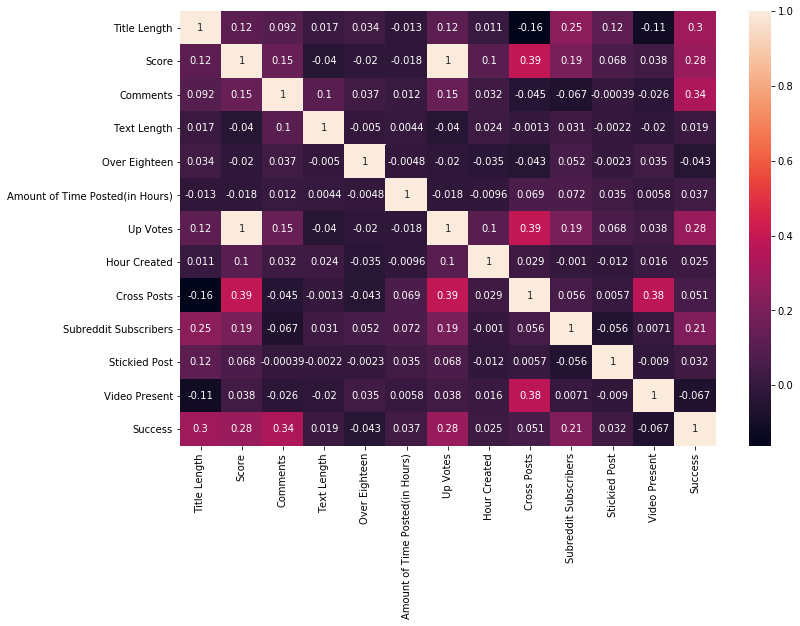

In [1224]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8))  
sns.heatmap(reddit.corr(), annot=True);

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

# Model 1: Random Forest Using Just the Subreddit

In [1301]:
# Creating dummy variables for the 'subreddit' column

sub_dummies = pd.get_dummies(reddit['Subreddit'])

In [1306]:
# Setting up X and y

X = sub_dummies
y = reddit['Success']

In [1293]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1294]:
# Random forest using gridsearch

rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators':range(1,30),
    'max_depth':[None, 2, 3, 4, 5]
}
gsrf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gsrf.fit(X_train, y_train)
predictions = gsrf.predict(X_test)
print(gsrf.best_params_)
print(gsrf.score(X_train, y_train))
print(gsrf.score(X_test, y_test))

{'max_depth': None, 'n_estimators': 2}
0.7160493827160493
0.7295081967213115


Confusion matrix 1
[[91 27]
 [39 87]]
Confusion Matrix 2
[[0.77 0.23]
 [0.31 0.69]]


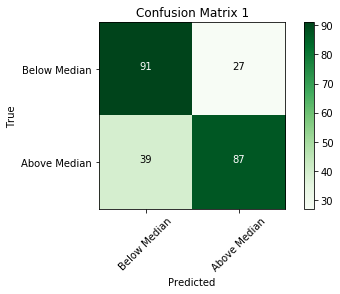

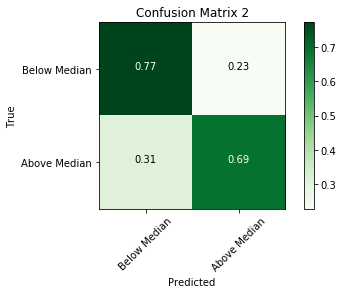

In [1295]:
# Plotting confusion matrix

cm = confusion_matrix(y_test, predictions)
classes = ['Below Median', 'Above Median']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix 2")
    else:
        print('Confusion matrix 1')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion Matrix 1')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Confusion Matrix 2')

plt.show()

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

# Model 2: Random Forest Adding Created Variables

In [1307]:
# Getting dummies for the 'Day Created' variable

day_dummies = pd.get_dummies(reddit['Day Created'])

In [1308]:
X = pd.concat([X, reddit[['Title Length']]], axis=1)
X = pd.concat([X, day_dummies], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1309]:
# Random forest with Gridsearch

rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators':range(1,30),
    'max_depth':[None, 2, 3, 4, 5]
}
gsrf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gsrf.fit(X_train, y_train)
predictions = gsrf.predict(X_test)
print(gsrf.best_params_)
print(gsrf.score(X_train, y_train))
print(gsrf.score(X_test, y_test))

{'max_depth': 4, 'n_estimators': 24}
0.7050754458161865
0.7131147540983607


Confusion matrix 1
[[94 24]
 [46 80]]
Confusion Matrix 2
[[0.8  0.2 ]
 [0.37 0.63]]


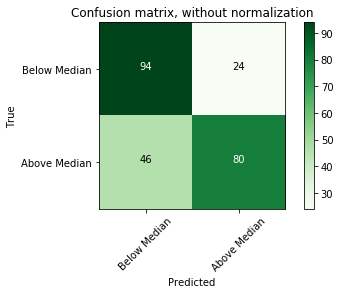

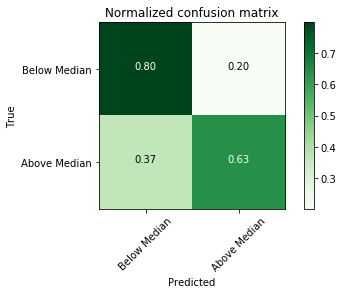

In [1310]:
# Plotting confusion matrix

cm = confusion_matrix(y_test, predictions)
classes = ['Below Median', 'Above Median']

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Model 3: Adding NLP

In [1311]:
# Creating function that removes punctuation, makes words lower case, splits words, and removes stop words

def preprocessing(post_titles):
    post_title_text = BeautifulSoup(post_titles).get_text()      
    letters_only = re.sub('[^a-zA-Z]', ' ', post_title_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    return(' '.join(meaningful_words))


In [1312]:
# Running data through the function

num_posts = reddit['Post Title'].size
clean_posts = []
for i in range(0, num_posts):                                                               
    clean_posts.append(preprocessing(reddit['Post Title'][i] ))

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/jordanarnold22/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and 

In [1313]:
# Using TFIDF vectorizer to score the importance of words

tvec = TfidfVectorizer(analyzer = "word", max_features = 50, ngram_range=(1,2)) 

train_data_features = tvec.fit_transform(clean_posts)
features_dataframe = pd.DataFrame(train_data_features.todense(), columns=tvec.get_feature_names())

In [1314]:
features_dataframe.sum(axis=0).sort_values(ascending=False)

til        26.366780
like       25.880144
world      22.963328
dog        20.719135
trump      18.987142
new        18.664916
today      18.627930
one        18.346912
years      17.160051
old        16.594826
people     15.911331
time       15.274031
got        15.214329
us         13.876208
day        13.768081
get        13.453857
two        13.270120
found      12.829148
best       12.585096
first      12.437447
year       12.383048
looks      11.776436
never      11.641378
little     11.566381
would      11.480714
made       11.334083
reddit     11.271134
took       11.150557
man        10.937686
th         10.937641
photo      10.703627
ban        10.694287
picture    10.229928
back       10.194751
friend     10.032784
cave        9.575780
make        9.504344
last        9.462436
kids        9.298222
work        9.294163
every       9.208320
boy         9.142332
see         9.008520
also        8.984911
go          8.510597
says        8.378732
good        8.107098
baby        7

In [1315]:
# Adding TFIDF data to the X dataframe

X = pd.concat([X, features_dataframe], axis=1)

In [1316]:
# Splitting data into separate strings above and below the median

above_thresh = reddit['Post Title'].loc[reddit['Comments'] > reddit['Comments'].median()]
below_thresh = reddit['Post Title'].loc[reddit['Comments'] <= reddit['Comments'].median()]
above_thresh_text = above_thresh.to_string()
below_thresh_text = below_thresh.to_string()

In [1317]:
# Setting up count vectorizer and fitting/transforming the corpus

cvec = CountVectorizer(stop_words='english', ngram_range=(1,2))
corpus = (above_thresh_text, below_thresh_text)
cvec.fit(corpus)
new_corpus = cvec.transform(corpus)

In [1318]:
# Putting results into a dataframe

df2 = pd.DataFrame(new_corpus.todense(),
                   columns=cvec.get_feature_names(),
                   index=['above_thresh', 'below_thresh'])

In [1319]:
# Checking out what words are most popular in successful posts

df2.T.sort_values('above_thresh', ascending=False).head(20)

,above_thresh,below_thresh
til,35,8
trump,18,0
got,12,5
friend,10,3
today,10,5
new,10,7
ban,9,2
world,9,8
year,9,6
like,8,12


In [1320]:
# Checking out what words are most popular in unsuccessful posts

df2.T.sort_values('below_thresh', ascending=False).head(20)

,above_thresh,below_thresh
dog,4,21
like,8,12
old,8,9
best,6,9
cat,0,9
til,35,8
just,6,8
time,4,8
looks,4,8
world,9,8


In [1321]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1322]:
# Random forest with Gridsearch

rf = RandomForestClassifier()
rf_params = {
    'n_estimators':range(1,30),
    'max_depth':[None, 2, 3, 4, 5]
}
gsrf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gsrf.fit(X_train, y_train)
print(gsrf.best_params_)
print(gsrf.score(X_train, y_train))
print(gsrf.score(X_test, y_test))
predictions = gsrf.predict(X_test)

{'max_depth': 5, 'n_estimators': 29}
0.7654320987654321
0.75


Confusion matrix 1
[[107  11]
 [ 50  76]]
Confusion Matrix 2
[[0.91 0.09]
 [0.4  0.6 ]]


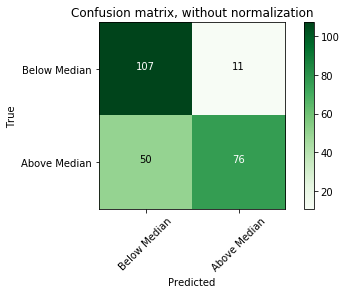

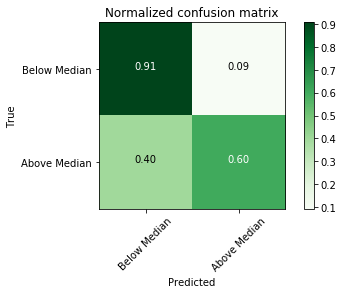

In [1323]:
# Plotting confusion matrix

cm = confusion_matrix(y_test, predictions)
classes = ['Below Median', 'Above Median']

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Repeat the model-building process with a non-tree-based method.

# Model 4: Logistic Regression With Just Subreddit Dummies

In [1333]:
# Setting up X and y

X = sub_dummies
y = reddit['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1334]:
logreg = LogisticRegression(random_state=42)
logreg_params = {
    'penalty':['l1', 'l2'],
    'C':[.1, .3, .5, .7, .9, 1.0]
}
gslog = GridSearchCV(logreg, param_grid=logreg_params, cv=5)
gslog.fit(X_train, y_train)
print(gslog.best_params_)
print(gslog.score(X_test, y_test))
predictions = gslog.predict(X_test)

{'C': 0.3, 'penalty': 'l2'}
0.7254098360655737


Confusion matrix 1
[[87 31]
 [36 90]]
Confusion Matrix 2
[[0.74 0.26]
 [0.29 0.71]]


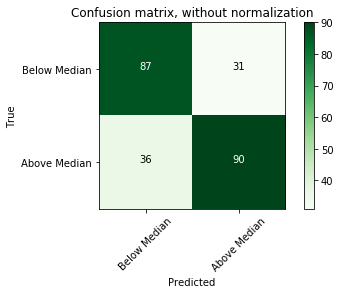

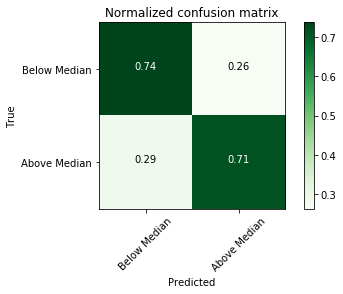

In [1335]:
# Plotting confusion matrix

cm = confusion_matrix(y_test, predictions)
classes = ['Below Median', 'Above Median']

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Model 5: Logistic Regression Adding Variables

In [1336]:
X = pd.concat([X, reddit[['Title Length']]], axis=1)
X = pd.concat([X, day_dummies], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1337]:
# Logistic regression model with Gridsearch checking for optimal penalty and C value

logreg = LogisticRegression(random_state=42)
logreg_params = {
    'penalty':['l1', 'l2'],
    'C':[.1, .3, .5, .7, .9, 1.0]
}
gslog = GridSearchCV(logreg, param_grid=logreg_params, cv=5)
gslog.fit(X_train, y_train)
print(gslog.best_params_)
print(gslog.score(X_test, y_test))
predictions = gslog.predict(X_test)

{'C': 0.5, 'penalty': 'l2'}
0.7336065573770492


Confusion matrix 1
[[95 23]
 [42 84]]
Confusion Matrix 2
[[0.81 0.19]
 [0.33 0.67]]


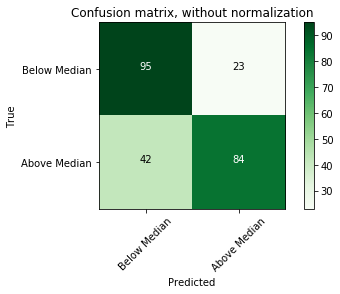

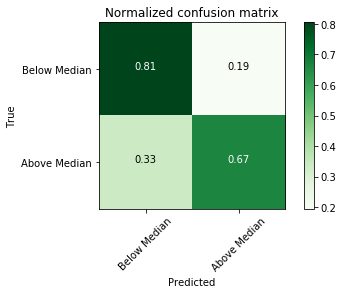

In [1338]:
cm = confusion_matrix(y_test, predictions)
classes = ['Below Median', 'Above Median']

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Model 6: Logistic Regression Adding NLP

In [1339]:
X = pd.concat([X, features_dataframe], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1340]:
# Logistic regression model with Gridsearch checking for optimal penalty and C value

logreg = LogisticRegression(random_state=42)
logreg_params = {
    'penalty':['l1', 'l2'],
    'C':[.1, .3, .5, .7, .9, 1.0]
}
gslog = GridSearchCV(logreg, param_grid=logreg_params, cv=5)
gslog.fit(X_train, y_train)
print(gslog.best_params_)
print(gslog.score(X_train, y_train))
print(gslog.score(X_test, y_test))
predictions = gslog.predict(X_test)

{'C': 0.5, 'penalty': 'l1'}
0.7256515775034293
0.7254098360655737


Confusion matrix 1
[[95 23]
 [44 82]]
Confusion Matrix 2
[[0.81 0.19]
 [0.35 0.65]]


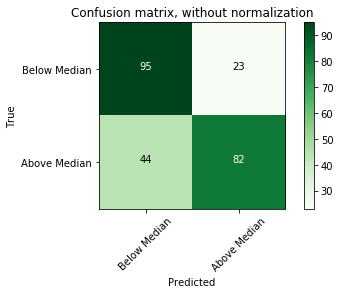

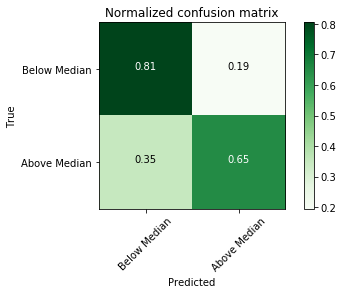

In [1341]:
# Plotting confusion matrix

cm = confusion_matrix(y_test, predictions)
classes = ['Below Median', 'Above Median']

cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

----------------------------------------------------------------------------

# Executive Summary

FiveThirtyEight is with out of doubt one of the most successful, and one of my personal favorite, analytics blogs out there today. The prospect of being able to write for such a well-respected blog is very exciting. It's only right that given the opportunity to pitch an idea to you I would analyze another website that I frequent, Reddit. Reddit has an average of 11 million posts per month, which needless to say is a huge amount. But what makes a Reddit post successful? Is there some kind of formula that you can follow to increase your chances of maximizing the amount of comments that your post receives?

With over 14 billion monthly page views, 2.8 million daily comments, and 58 million daily votes, Reddit is a massive market for businesses looking to promote themselves. It provides a platform for anybody to create a community around a product. For example, the subreddit for the tv show Westworld has 469,000 subscribers that are able to connect with other fans and discuss the show, which in turn increases their interest in watching. It's easy to see the need for analytics on how to be a successful Reddit user.

Looking into how to maximize the amount of comments on a given Reddit post I scraped the 1,000 top Reddit posts of the past month and looked at a number of features. I looked at the length of the title, the length of the text, the subreddit that the post came from, the hour that the post was created, the day of the week that the post was created, and the frequency of words used in the title. Out of these, the subreddit and the length of the title were my most successful variables. A shorter title length has a greater result of being successful, which could potentially be attributed to the decreased attention spans of the younger generations. I created several models, a few of which are able to predict the success of a Reddit post (above/below the median of my dataset) with 75% accuracy.

I have been a longtime reader of FiveThirtyEight and I would jump at the opportunity to be able to publish some of my work on a publication that has meant so much to my development as a data scientist. I believe that my work has the potential to change the ways that people market on Reddit by maximizing their potential to be successful. Not to mention, I think it would please the existing FiveThirtyEight readers and maybe even bring some new ones on board. I look forward to presenting my idea to you and I hope we can make it happen!